In [1]:
import gymnasium as gym
from lm_human_preferences.env.rlhf_env import RLHFEnv
from lm_human_preferences.data.base import QueryData
from transformers import AutoTokenizer
from lm_human_preferences.lm.reward import RewardModel
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

gym.envs.register(
    id='RLHFEnv-v0',
    entry_point='lm_human_preferences.env.rlhf_env:RLHFEnv',
    kwargs={
        'ref_model_name': 'openai-community/gpt2',
        'reward_model': RewardModel.from_pretrained('../models/reward_model'),
        'dataset': QueryData.from_openai_format(
            AutoTokenizer.from_pretrained('openai-community/gpt2'),
            '../data/descriptiveness_offline_5k'
        ),
        'kl_coef': 0.01,
        'max_generation': 64,
        'device': device,
        'seed': 42
    }
)

ENV_NAME = 'RLHFEnv-v0'

/home/ez/.cache/pypoetry/virtualenvs/finetuning-lm-from-human-preferences-4SAAosyV-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Normal
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Optional, Union
from transformers import AutoModelForCausalLM, AutoModelForSequenceClassification, AutoTokenizer
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
from typing import Callable


import random

class RolloutBuffer:
    """
    Buffer to store experiences collected during rollouts.
    """
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.logprobs = []
        self.state_values = []
        self.is_terminals = []
    
    def clear(self):
        """Clear the buffer."""
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()
        self.logprobs.clear()
        self.state_values.clear()
        self.is_terminals.clear()
    
    def __len__(self) -> int:
        return len(self.states)
    
    def __getitem__(self, idx) -> tuple:
        self.__assert_all_equal_size()
        return self.states[idx], self.actions[idx], self.rewards[idx], self.logprobs[idx], self.state_values[idx], self.is_terminals[idx]
    
    def shuffle(self) -> None:
        self.__assert_all_equal_size()
        
        indices = list(range(len(self.states)))
        random.shuffle(indices)
        
        self.states = [self.states[i] for i in indices]
        self.actions = [self.actions[i] for i in indices]
        self.rewards = [self.rewards[i] for i in indices]
        self.logprobs = [self.logprobs[i] for i in indices]
        self.state_values = [self.state_values[i] for i in indices]
        self.is_terminals = [self.is_terminals[i] for i in indices]

    def sample(self, n: int) -> tuple:
        self.__assert_all_equal_size()
        
        indices = random.sample(list(range(len(self.states))), n)

        states = [self.states[i] for i in indices]
        actions = [self.actions[i] for i in indices]
        rewards = [self.rewards[i] for i in indices]
        logprobs = [self.logprobs[i] for i in indices]
        state_values = [self.state_values[i] for i in indices]
        is_terminals = [self.is_terminals[i] for i in indices]
        
        return states, actions, rewards, logprobs, state_values, is_terminals
    
    def __assert_all_equal_size(self):
        assert len(self.states) == len(self.actions) == len(self.rewards) == len(self.logprobs) == len(self.state_values) == len(self.is_terminals), \
            "Buffer states, actions, rewards, logprobs, state_values, and is_terminals must have the same length got {}".format(
                len(self.states), 
                len(self.actions), 
                len(self.rewards), 
                len(self.logprobs), 
                len(self.state_values), 
                len(self.is_terminals)
            )

class LMActorNetwork(nn.Module):
    """
    Actor network for continuous or discrete action spaces.
    """
    def __init__(self, model_name: str, pad_token_id: int):
        super(LMActorNetwork, self).__init__()
        
        self.lm_model = AutoModelForCausalLM.from_pretrained(model_name)
        self.lm_model.config.pad_token_id = pad_token_id
        self.pad_token_id = pad_token_id
    
    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network. Return action probs"""
        assert state.ndim in [1, 2], "State must be a 1D or 2D tensor got : {}".format(state)
        single = (state.ndim == 1)
        if single:
            state = state.unsqueeze(dim=0) # [1, seq_len]
        
        input_ids = state
        attention_mask = input_ids != self.pad_token_id
        logits = self.lm_model(input_ids=input_ids, attention_mask=attention_mask).logits # [batch_size, seq_len, vocab_size]
        next_token_logits = logits[:, -1, :]  # [batch_size, vocab_size]
        if single:
            return next_token_logits[0] # [vocab_size]
        return next_token_logits # [batch_size, vocab_size]

class LMCriticNetwork(nn.Module):
    """
    Critic network that estimates the value of a state.
    """
    def __init__(self, model_name: str, pad_token_id: int):
        super(LMCriticNetwork, self).__init__()
        
        self.lm_model = AutoModelForSequenceClassification.from_pretrained(
            model_name, 
            num_labels=1
        )
        self.lm_model.config.pad_token_id = pad_token_id
        
        self.pad_token_id = pad_token_id
    
    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network. Return tensor([1])"""
        assert state.ndim in [1, 2], "State must be a 1D or 2D tensor got : {}".format(state)
        single = (state.ndim == 1)
        if single:
            state = state.unsqueeze(dim=0) # [1, seq_len]
        
        input_ids = state
        attention_mask = input_ids != self.pad_token_id
        logits = self.lm_model(input_ids=input_ids, attention_mask=attention_mask).logits # [batch_size, 1]
        logits = logits.squeeze(-1)
        
        if single:
            return logits[0] # 0-D tensor
        return logits # [batch_size]
    
class MLPActorNetwork(nn.Module):
    """
    Actor network using a Multi-Layer Perceptron for continuous or discrete action spaces.
    """
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super(MLPActorNetwork, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network. Return action probs"""
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x) # [batch_size, output_dim]
        return logits

class MLPCriticNetwork(nn.Module):
    """
    Critic network using a Multi-Layer Perceptron to estimate the value of a state.
    """
    def __init__(self, input_dim: int, hidden_dim: int):
        super(MLPCriticNetwork, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
    
    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network. Return state value"""
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        value = self.fc3(x)
        return value

In [3]:
import copy

class PPOConfig:
    # TODO: Investigate the following hyperparameter clip_coef, vf_coef, ent_coef, norm_adv, max_grad_norm
    def __init__(
        self,
        lr_actor: float = 3e-4,
        lr_critic: float = 1e-3,
        gamma: float = 0.99,
        update_epochs: int = 10,
        eps_clip: float = 0.2,
        minibatch_size: int = 8,
        pad_obs: bool = False,
        int_obs: bool = False,
    ):
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.gamma = gamma
        self.update_epochs = update_epochs
        self.eps_clip = eps_clip
        self.minibatch_size = minibatch_size
        self.pad_obs = pad_obs
        self.int_obs = int_obs
        
class PPO:
    """
    Proximal Policy Optimization algorithm with clipped objective.
    """
    def __init__(
        self, 
        actor: nn.Module,
        critic: nn.Module,
        config: PPOConfig, 
        device: str = 'cuda',
    ):
        """
        Initialize the PPO agent.
        
        Args:
            config: PPOConfig, 
            device: str = 'cuda',
        ):
        """
        self.config = config
        self.device = device
        self.gamma = config.gamma
        self.eps_clip = config.eps_clip
        self.update_epochs = config.update_epochs
        self.minibatch_size = config.minibatch_size
        self.lr_actor = config.lr_actor
        self.lr_critic = config.lr_critic
        self.pad_obs = config.pad_obs
        self.int_obs = config.int_obs
        
        self.buffer = RolloutBuffer()
        
        self.actor = actor.to(device)
        self.critic = critic.to(device)
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.lr_critic)
        
        self.actor_old = copy.deepcopy(self.actor)
        self.actor_old.requires_grad_(False)
        
        self.mse_loss = nn.MSELoss()
    
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """
        Select an action based on the current policy.
        
        Args:
            state: Current state observation
            
        Returns:
            Selected action
        """
        with torch.no_grad():
            # TODO: Dynamically determine the dtype based on the observation space
            state = torch.tensor(state, dtype=torch.int32 if self.int_obs else torch.float32).to(device)            
            action_logits = self.actor_old(state)
            action_dist = Categorical(logits=action_logits)
            
            action = action_dist.sample()
            action_logprob = action_dist.log_prob(action)
            state_val = self.critic(state)
            
            # Store experience in buffer
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)
            
            return action.item()
    
    def evaluate(self, states: torch.Tensor, actions: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Evaluate actions given states using the current policy.
        
        Args:
            states: Batch of states
            actions: Batch of actions
            
        Returns:
            log_probs, state_values, dist_entropy
        """
        action_logits = self.actor(states)
        action_dist = Categorical(logits=action_logits)
        
        action_log_probs = action_dist.log_prob(actions)
        dist_entropy = action_dist.entropy().mean()
        
        state_values = self.critic(states)
        
        return action_log_probs, state_values, dist_entropy
    
    def update(self):
        """
        Update policy and value networks using PPO algorithm.
        """
        # Calculate discounted rewards and advantages
        rewards = []
        discounted_reward = 0
        
        # Compute GAE
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        _, old_states, old_actions, old_logprobs, old_state_values = self._to_tensor(
            self.buffer.rewards, 
            self.buffer.states, 
            self.buffer.actions, 
            self.buffer.logprobs, 
            self.buffer.state_values
        )
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        
        # Normalize rewards
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)
        # Calculate and normalize advantages
        advantages = rewards - old_state_values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-7)
        
        T = rewards.size(0)
        for name, tensor in [
            ("rewards", rewards),
            ("old_actions", old_actions),
            ("old_logprobs", old_logprobs),
            ("old_state_values", old_state_values)
        ]:
            assert tensor.dim() == 1, (
                f"{name} must be 1-D of length {T}, but got shape {tuple(tensor.shape)}"
            )
            assert tensor.size(0) == T, (
                f"{name} length {tensor.size(0)} != expected {T}"
            )
        assert advantages.dim() == 1 and advantages.size(0) == T, (
            f"advantages must be 1-D of length {T}, got {tuple(advantages.shape)}"
        )

        # Optimize policy for K epochs
        for k in range(self.update_epochs):
            indexes = torch.randperm(len(rewards))
            if self.minibatch_size == -1:
                minibatch_size = len(rewards)
            else:
                minibatch_size = self.minibatch_size
                
            for i in range(0, len(rewards), minibatch_size):
                batch_indexes = indexes[i:i + minibatch_size]
                b_old_states = old_states[batch_indexes]
                b_old_actions = old_actions[batch_indexes]
                b_old_logprobs = old_logprobs[batch_indexes]
                b_rewards = rewards[batch_indexes]
                b_advantages = advantages[batch_indexes]
                # b_old_states = old_states
                # b_old_actions = old_actions
                # b_old_logprobs = old_logprobs
                # b_rewards = rewards
                # b_advantages = advantages

                # Evaluate old actions and values
                b_logprobs, b_state_values, dist_entropy = self.evaluate(b_old_states, b_old_actions)
                b_state_values = b_state_values.squeeze(-1)
                
                for name, tensor in [
                    ("b_logprobs", b_logprobs),
                    ("b_state_values", b_state_values)
                ]:
                    assert tensor.dim() == 1 and tensor.size(0) == minibatch_size or tensor.size(0) == len(rewards) % minibatch_size, (
                        f"{name} must be 1-D of length {minibatch_size} or {len(rewards) % minibatch_size}, got {tuple(tensor.shape)}"
                    )
                
                # Calculate ratios for importance sampling
                ratios = torch.exp(b_logprobs - b_old_logprobs)
                
                # Calculate surrogate losses
                surr1 = ratios * b_advantages
                surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * b_advantages
                
                # PPO clipped objective with value function loss and entropy bonus
                actor_loss = -torch.min(surr1, surr2).mean()
                critic_loss = self.mse_loss(b_state_values, b_rewards)
                entropy_loss = -0.01 * dist_entropy  # Entropy bonus for exploration
                
                # Combined loss
                loss = actor_loss + 0.5 * critic_loss + entropy_loss
                
                # Take gradient step
                self.actor_optimizer.zero_grad()
                self.critic_optimizer.zero_grad()
                loss.backward()
                self.actor_optimizer.step()
                self.critic_optimizer.step()
        
        # Update old policy
        self.actor_old.load_state_dict(self.actor.state_dict())
        self.buffer.clear()
    
    def _to_tensor(self, rewards: List[float], states: List[np.ndarray], actions: List[np.ndarray], logprobs: List[np.ndarray], state_values: List[np.ndarray]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        if self.pad_obs:
            # Import pad_sequence if needed for padding observations
            from torch.nn.utils.rnn import pad_sequence
            old_states = pad_sequence(states, batch_first=True, padding_value=actor.pad_token_id, padding_side='left').to(device)
        else:
            old_states = torch.stack(states, dim=0).to(device)
        old_actions = torch.stack(actions, dim=0).detach().to(device)
        old_logprobs = torch.stack(logprobs, dim=0).detach().to(device)
        old_state_values = torch.stack(state_values, dim=0).squeeze().detach().to(device)
        return rewards, old_states, old_actions, old_logprobs, old_state_values
    
    def save(self, checkpoint_path: str):
        """
        Save model parameters.
        
        Args:
            checkpoint_path: Path to save the model
        """
        torch.save({
            'actor': self.actor.state_dict(),
            'critic': self.critic.state_dict(),
            'actor_old': self.actor_old.state_dict(),
        }, checkpoint_path)
    
    def load(self, checkpoint_path: str):
        """
        Load model parameters.
        
        Args:
            checkpoint_path: Path to load the model from
        """
        checkpoint = torch.load(checkpoint_path, map_location=device)
        self.actor.load_state_dict(checkpoint['actor'])
        self.critic.load_state_dict(checkpoint['critic'])
        self.actor_old.load_state_dict(checkpoint['actor_old'])

def train(env_name: str, actor: nn.Module, critic: nn.Module, ppo_config: PPOConfig, max_episodes: int = 1000, max_timesteps: int = 1000, 
        update_interval: int = 100, save_interval: int = 100, callback: Optional[Callable] = None,
        log_interval: int = 10, device='cuda') -> List[float]:
    """
    Train a PPO agent in a given environment.
    
    Args:
        env_name: Name of the gym environment
        max_episodes: Maximum number of episodes for training
        max_timesteps: Maximum timesteps in one episode
        update_interval: Update policy every n episodes
        save_interval: Save model in the interval
    
    Returns:
        List of average rewards per episode
    """
    # Create environment
    env = gym.make(env_name)
    
    # Initialize PPO agent
    ppo_agent = PPO(
        actor,
        critic,
        ppo_config,
        device,
    )
    
    # Logging variables
    running_reward = 0
    time_step = 0
    
    # Training loop
    episode_rewards = []
    
    for episode in range(1, max_episodes+1):
        state, _ = env.reset()
        episode_reward = 0
        
        for t in range(1, max_timesteps+1):
            # Select action
            action = ppo_agent.select_action(state)
            
            # Take action in environment
            next_state, reward, done, truncated, _ = env.step(action)
            
            # Store experience in buffer
            ppo_agent.buffer.rewards.append(reward)
            ppo_agent.buffer.is_terminals.append(done)
            
            time_step += 1
            episode_reward += reward

            state = next_state
            
            if done or truncated:
                break
        
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
        episode_rewards.append(running_reward)

        if episode % log_interval == 0:
            if callback is not None:
                callback(state, action, reward, done, truncated, episode, running_reward)
            print(f"Episode {episode}, Running Reward: {running_reward:.2f}")

        # Update if its time
        if episode % update_interval == 0:
            # Make sure we have enough data in the buffer before updating
            if len(ppo_agent.buffer.states) > 0:  # Only update if buffer contains experiences
                ppo_agent.update()
            else:
                print(f"Warning: Episode {episode} - Buffer is empty, skipping update")
        
        # Save model
        if episode % save_interval == 0:
            ppo_agent.save(f"./PPO_{env_name}_{episode}.pth")
    
    env.close()
    return episode_rewards

In [4]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
actor = LMActorNetwork(
    model_name="openai-community/gpt2",
    pad_token_id=tokenizer.eos_token_id,
)
critic = LMCriticNetwork(
    model_name="openai-community/gpt2",
    pad_token_id=tokenizer.eos_token_id,
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
ppo_config = PPOConfig(
    lr_actor=3e-4,
    lr_critic=1e-3,
    gamma=0.99,
    eps_clip=0.2,
    update_epochs=10,
    minibatch_size=-1,
    pad_obs=True,
    int_obs=True,
)
callback = (
    lambda state, action, reward, done, truncated, episode, running_reward: (
        print("="*20),
        print('[STATE]:\n', tokenizer.decode(state)),
        print('[ACTION]:\n', tokenizer.decode(action)),
        print('[REWARD]:\n', reward),
        print('[DONE]:\n', done),
        print('[TRUNCATED]:\n', truncated),
        print("="*20)
    )
)
rewards_discrete = train(
    env_name=ENV_NAME,
    actor=actor,
    critic=critic,
    ppo_config=ppo_config,
    max_episodes=1000, 
    max_timesteps=1000, 
    update_interval=5, 
    save_interval=10,
    callback=callback,
    log_interval=5
)

[STATE]:
  It was a strip of silver foil, carefully folded and twisted around her finger.

She refused to think of what her sister would say about it, and remembered instead how she'd felt when Bobby put it there.

Marry me, he'd said, on bended knee.

She preferred William, hanging in that, like the butterflies in meu take on wings, now disquieting me.

It wasn't like we wouldn't share this experience over and over again, we're all in this day and age.

I'm not here to judge and reprimand,
[ACTION]:
 ,
[REWARD]:
 -0.0038928186893463085
[DONE]:
 False
[TRUNCATED]:
 True
Episode 5, Running Reward: 12.85


KeyboardInterrupt: 

In [6]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

actor = MLPActorNetwork(
    env.observation_space.shape[0],
    64,
    env.action_space.n,
)
critic = MLPCriticNetwork(
    env.observation_space.shape[0],
    64,
)

ppo_config = PPOConfig(
    lr_actor=3e-4,
    lr_critic=1e-3,
    gamma=0.99,
    eps_clip=0.2,
    update_epochs=10,
    minibatch_size=512
)
rewards_discrete = train(
    env_name=env_name,
    actor=actor,
    critic=critic,
    ppo_config=ppo_config,
    max_episodes=4_000, 
    max_timesteps=1000, 
    update_interval=100, 
    save_interval=1000,
    log_interval=100
)

Episode 100, Running Reward: 24.80
Episode 200, Running Reward: 28.86
Episode 300, Running Reward: 31.29
Episode 400, Running Reward: 49.25


KeyboardInterrupt: 

# Original Impl

In [21]:
"""
Proximal Policy Optimization (PPO) Implementation in PyTorch
"""

import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Normal
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Optional, Union

# Set device to cpu or cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class RolloutBuffer:
    """
    Buffer to store experiences collected during rollouts.
    """
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.logprobs = []
        self.state_values = []
        self.is_terminals = []
    
    def clear(self):
        """Clear the buffer."""
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()
        self.logprobs.clear()
        self.state_values.clear()
        self.is_terminals.clear()

class ActorNetwork(nn.Module):
    """
    Actor network for continuous or discrete action spaces.
    """
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 64, 
                 continuous: bool = False, action_std_init: float = 0.6):
        super(ActorNetwork, self).__init__()
        
        self.continuous = continuous
        
        # Common layers
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        
        # Output layers based on action space type
        if continuous:
            self.mean_layer = nn.Linear(hidden_dim, action_dim)
            self.action_std = nn.Parameter(torch.full((action_dim,), action_std_init))
        else:
            self.categorical = nn.Linear(hidden_dim, action_dim)
            
    def forward(self, state: torch.Tensor) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """Forward pass through the network."""
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        
        if self.continuous:
            action_mean = self.mean_layer(x)
            action_std = self.action_std.expand_as(action_mean)
            return action_mean, action_std
        else:
            action_probs = torch.softmax(self.categorical(x), dim=-1)
            return action_probs
    
    def set_action_std(self, new_action_std: float):
        """Set the action standard deviation (for continuous action spaces)."""
        if self.continuous:
            self.action_std = nn.Parameter(torch.full(self.action_std.shape, new_action_std))
        else:
            print("WARNING: Calling set_action_std on discrete action space policy")

class CriticNetwork(nn.Module):
    """
    Critic network that estimates the value of a state.
    """
    def __init__(self, state_dim: int, hidden_dim: int = 64):
        super(CriticNetwork, self).__init__()
        
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, 1)
        
    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network."""
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        value = self.value(x)
        
        return value

class PPO:
    """
    Proximal Policy Optimization algorithm with clipped objective.
    """
    def __init__(
        self, 
        state_dim: int, 
        action_dim: int,
        lr_actor: float = 3e-4,
        lr_critic: float = 1e-3,
        gamma: float = 0.99,
        K_epochs: int = 10,
        eps_clip: float = 0.2,
        has_continuous_action_space: bool = False,
        action_std_init: float = 0.6,
        hidden_dim: int = 64
    ):
        """
        Initialize the PPO agent.
        
        Args:
            state_dim: Dimension of state space
            action_dim: Dimension of action space
            lr_actor: Learning rate for actor network
            lr_critic: Learning rate for critic network
            gamma: Discount factor
            K_epochs: Number of epochs to update policy
            eps_clip: Clip parameter for PPO
            has_continuous_action_space: Whether the action space is continuous
            action_std_init: Initial standard deviation for action distribution
            hidden_dim: Hidden dimension size for neural networks
        """
        self.has_continuous_action_space = has_continuous_action_space
        self.action_dim = action_dim
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        # Initialize buffer
        self.buffer = RolloutBuffer()
        
        # Initialize actor
        self.actor = ActorNetwork(
            state_dim, 
            action_dim, 
            hidden_dim=hidden_dim, 
            continuous=has_continuous_action_space, 
            action_std_init=action_std_init
        ).to(device)
        
        # Initialize critic
        self.critic = CriticNetwork(state_dim, hidden_dim=hidden_dim).to(device)
        
        # Set optimizers for both networks
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)
        
        # Initialize old policy (for importance sampling)
        self.actor_old = ActorNetwork(
            state_dim, 
            action_dim, 
            hidden_dim=hidden_dim, 
            continuous=has_continuous_action_space, 
            action_std_init=action_std_init
        ).to(device)
        
        # Copy parameters from current policy to old policy
        self.actor_old.load_state_dict(self.actor.state_dict())
        
        # Loss function for value network
        self.MseLoss = nn.MSELoss()
        
        # Set initial action standard deviation
        if has_continuous_action_space:
            self.action_std = action_std_init
    
    def set_action_std(self, new_action_std: float):
        """
        Set the action standard deviation for continuous action spaces.
        
        Args:
            new_action_std: New standard deviation value
        """
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.actor.set_action_std(new_action_std)
            self.actor_old.set_action_std(new_action_std)
        else:
            print("WARNING: Calling set_action_std on discrete action space policy")
    
    def decay_action_std(self, action_std_decay_rate: float, min_action_std: float):
        """
        Decay the action standard deviation based on the decay rate.
        
        Args:
            action_std_decay_rate: Rate at which to decay the std
            min_action_std: Minimum std value
        """
        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = max(self.action_std, min_action_std)
            self.set_action_std(self.action_std)
            print(f"Setting actor output action_std to: {self.action_std}")
        else:
            print("WARNING: Calling decay_action_std on discrete action space policy")
    
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """
        Select an action based on the current policy.
        
        Args:
            state: Current state observation
            
        Returns:
            Selected action
        """
        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            
            if self.has_continuous_action_space:
                action_mean, action_std = self.actor_old(state)
                action_dist = Normal(action_mean, action_std)
            else:
                action_probs = self.actor_old(state)
                action_dist = Categorical(action_probs)
            
            action = action_dist.sample()
            action_logprob = action_dist.log_prob(action)
            state_val = self.critic(state)
            
            # Store experience in buffer
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)
            
            if self.has_continuous_action_space:
                return action.detach().cpu().numpy().flatten()
            else:
                return action.item()
    
    def evaluate(self, states: torch.Tensor, actions: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Evaluate actions given states using the current policy.
        
        Args:
            states: Batch of states
            actions: Batch of actions
            
        Returns:
            log_probs, state_values, dist_entropy
        """
        if self.has_continuous_action_space:
            action_mean, action_std = self.actor(states)
            action_dist = Normal(action_mean, action_std)
            
            # For continuous action spaces, calculate the log probability of each action dimension
            if actions.dim() > action_mean.dim():
                actions = actions.squeeze(-1)
            
            action_log_probs = action_dist.log_prob(actions).sum(dim=1)
            dist_entropy = action_dist.entropy().sum(dim=1).mean()
            
        else:
            action_probs = self.actor(states)
            action_dist = Categorical(action_probs)
            
            action_log_probs = action_dist.log_prob(actions)
            dist_entropy = action_dist.entropy().mean()
        
        state_values = self.critic(states)
        
        return action_log_probs, state_values, dist_entropy
    
    def update(self):
        """
        Update policy and value networks using PPO algorithm.
        """
        # Calculate discounted rewards and advantages
        rewards = []
        discounted_reward = 0
        
        # Compute discounted rewards
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Convert lists to tensors
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        old_states = torch.stack(self.buffer.states, dim=0).detach().to(device)
        old_actions = torch.stack(self.buffer.actions, dim=0).detach().to(device)
        old_logprobs = torch.stack(self.buffer.logprobs, dim=0).detach().to(device)
        old_state_values = torch.stack(self.buffer.state_values, dim=0).squeeze().detach().to(device)
        
        # Normalize rewards
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)
        
        # Calculate advantages
        advantages = rewards - old_state_values
        
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-7)
        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):
            # Evaluate old actions and values
            logprobs, state_values, dist_entropy = self.evaluate(old_states, old_actions)
            
            # Match dimensions with rewards
            state_values = state_values.squeeze()
            
            # Calculate ratios for importance sampling
            ratios = torch.exp(logprobs - old_logprobs)
            
            # Calculate surrogate losses
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            
            # PPO clipped objective with value function loss and entropy bonus
            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = self.MseLoss(state_values, rewards)
            entropy_loss = -0.01 * dist_entropy  # Entropy bonus for exploration
            
            # Combined loss
            loss = actor_loss + 0.5 * critic_loss + entropy_loss
            
            # Take gradient step
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
        
        # Update old policy
        self.actor_old.load_state_dict(self.actor.state_dict())
        
        # Clear buffer
        self.buffer.clear()
    
    def save(self, checkpoint_path: str):
        """
        Save model parameters.
        
        Args:
            checkpoint_path: Path to save the model
        """
        torch.save({
            'actor': self.actor.state_dict(),
            'critic': self.critic.state_dict(),
            'actor_old': self.actor_old.state_dict(),
        }, checkpoint_path)
    
    def load(self, checkpoint_path: str):
        """
        Load model parameters.
        
        Args:
            checkpoint_path: Path to load the model from
        """
        checkpoint = torch.load(checkpoint_path, map_location=device)
        self.actor.load_state_dict(checkpoint['actor'])
        self.critic.load_state_dict(checkpoint['critic'])
        self.actor_old.load_state_dict(checkpoint['actor_old'])

def train(env_name: str, max_episodes: int = 1000, max_timesteps: int = 1000, 
          update_timestep: int = 4000, log_interval: int = 20, save_interval: int = 100,
          has_continuous_action_space: bool = False, action_std_init: float = 0.6) -> List[float]:
    """
    Train a PPO agent in a given environment.
    
    Args:
        env_name: Name of the gym environment
        max_episodes: Maximum number of episodes for training
        max_timesteps: Maximum timesteps in one episode
        update_timestep: Update policy every n timesteps
        log_interval: Print avg reward in the interval
        save_interval: Save model in the interval
        has_continuous_action_space: Whether the environment has continuous action space
        action_std_init: Initial action standard deviation
    
    Returns:
        List of average rewards per episode
    """
    # Create environment
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    
    if has_continuous_action_space:
        action_dim = env.action_space.shape[0]
    else:
        action_dim = env.action_space.n
    
    # Initialize PPO agent
    ppo_agent = PPO(
        state_dim=state_dim,
        action_dim=action_dim,
        lr_actor=3e-4,
        lr_critic=1e-3,
        gamma=0.99,
        K_epochs=10,
        eps_clip=0.2,
        has_continuous_action_space=has_continuous_action_space,
        action_std_init=action_std_init
    )
    
    # Logging variables
    running_reward = 0
    avg_length = 0
    time_step = 0
    
    # Training loop
    episode_rewards = []
    
    for episode in range(1, max_episodes+1):
        state, _ = env.reset()
        episode_reward = 0
        
        for t in range(1, max_timesteps+1):
            # Select action
            action = ppo_agent.select_action(state)
            
            # Take action in environment
            next_state, reward, done, truncated, _ = env.step(action)
            
            # Store experience in buffer
            ppo_agent.buffer.rewards.append(reward)
            ppo_agent.buffer.is_terminals.append(done)
            
            time_step += 1
            episode_reward += reward
            state = next_state
            
            # Update if its time
            if time_step % update_timestep == 0:
                ppo_agent.update()
            
            if done or truncated:
                break
        
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
        episode_rewards.append(running_reward)
        
        # Logging
        if episode % log_interval == 0:
            print(f"Episode: {episode}, Avg. Reward: {running_reward:.2f}")
        
        # Save model
        if episode % save_interval == 0:
            ppo_agent.save(f"./PPO_{env_name}_{episode}.pth")
    
    env.close()
    return episode_rewards

def plot_learning_curve(rewards: List[float], title: str = "Learning Curve"):
    """
    Plot the learning curve based on rewards.
    
    Args:
        rewards: List of rewards
        title: Title for the plot
    """
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.grid(True)
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()

rewards_discrete = train(
    env_name="CartPole-v1",
    max_episodes=5000,
    max_timesteps=1000,
    has_continuous_action_space=False,
    log_interval=100,
)
# plot_learning_curve(rewards_discrete, "CartPole-v1 Learning Curve")

Episode: 100, Avg. Reward: 18.61
Episode: 200, Avg. Reward: 18.00
Episode: 300, Avg. Reward: 23.36
Episode: 400, Avg. Reward: 22.36
Episode: 500, Avg. Reward: 26.66
Episode: 600, Avg. Reward: 27.47
Episode: 700, Avg. Reward: 23.99
Episode: 800, Avg. Reward: 28.97
Episode: 900, Avg. Reward: 26.57
Episode: 1000, Avg. Reward: 29.87
Episode: 1100, Avg. Reward: 34.25
Episode: 1200, Avg. Reward: 33.61
Episode: 1300, Avg. Reward: 41.06
Episode: 1400, Avg. Reward: 35.69
Episode: 1500, Avg. Reward: 39.38
Episode: 1600, Avg. Reward: 50.39
Episode: 1700, Avg. Reward: 52.65
Episode: 1800, Avg. Reward: 66.88
Episode: 1900, Avg. Reward: 119.23
Episode: 2000, Avg. Reward: 131.64
Episode: 2100, Avg. Reward: 200.44
Episode: 2200, Avg. Reward: 252.04
Episode: 2300, Avg. Reward: 385.38
Episode: 2400, Avg. Reward: 361.64


KeyboardInterrupt: 

# Loading an Agent

In [ ]:
ppo_agent = PPO(actor, critic, actor_old, ppo_config)
ppo_agent.load("./PPO_RLHFEnv-v0_2.pth")
ppo_agent.actor

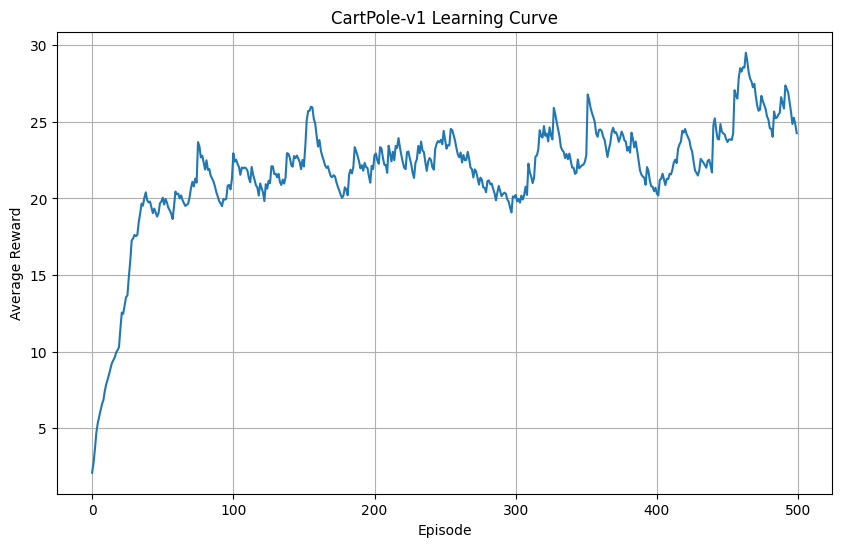

In [ ]:
def plot_learning_curve(rewards: List[float], title: str = "Learning Curve"):
    """
    Plot the learning curve based on rewards.
    
    Args:
        rewards: List of rewards
        title: Title for the plot
    """
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.grid(True)
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()

plot_learning_curve(rewards_discrete, "CartPole-v1 Learning Curve")

In [ ]:
# For continuous action space (Pendulum-v1)
rewards_continuous = train(
    env_name="Pendulum-v1",
    max_episodes=1000,
    max_timesteps=1000,
    has_continuous_action_space=True,
    action_std_init=0.6
)
plot_learning_curve(rewards_continuous, "Pendulum-v1 Learning Curve")